In [6]:
import numpy as np
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import easyocr

%matplotlib inline

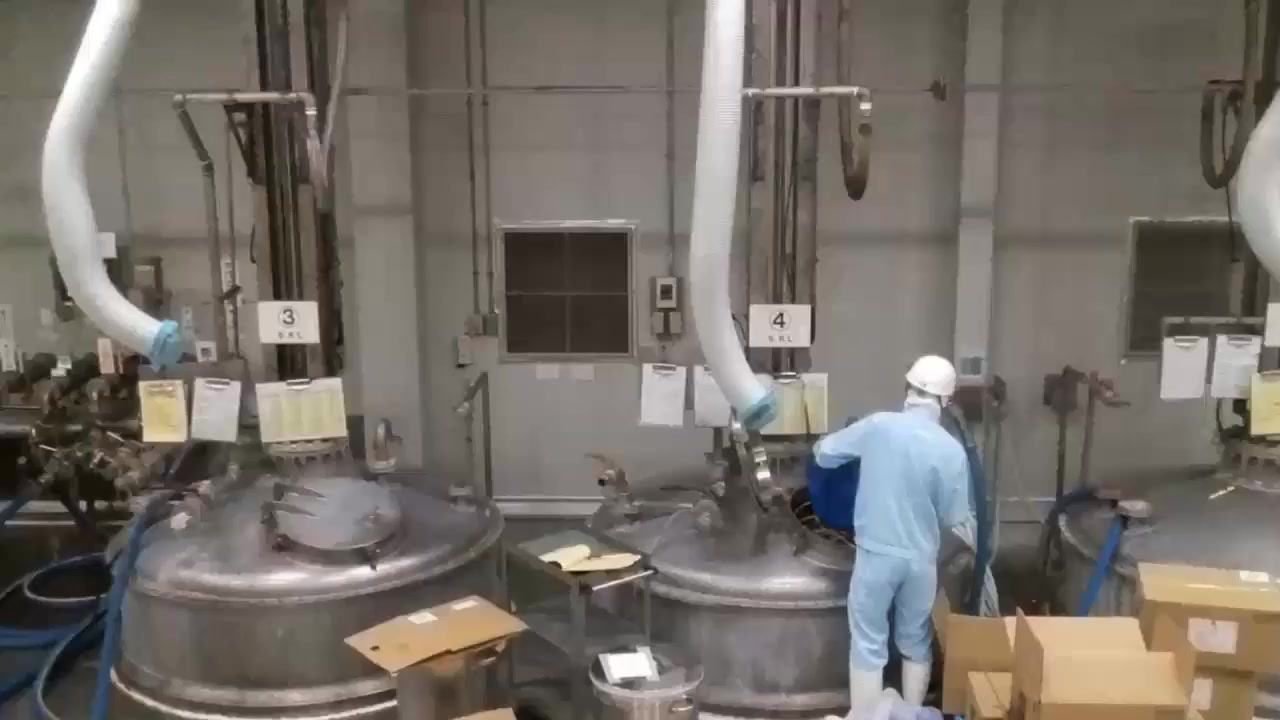

In [2]:
image = '../data/frame.jpg'

img = Image.open(image)
display(img)

In [3]:
# yolo

yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5x6")

Using cache found in /home/rkb/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-12 Python-3.8.6 torch-1.11.0+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 5927MiB)

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [4]:
detection = yolo_model(img)
detection.print()
coords = detection.xyxy[0]
coords

image 1/1: 720x1280 1 person
Speed: 20.6ms pre-process, 84.6ms inference, 327.2ms NMS per image at shape (1, 3, 384, 640)


tensor([[8.06579e+02, 3.51788e+02, 9.77370e+02, 7.14150e+02, 9.24226e-01, 0.00000e+00]], device='cuda:0')

True


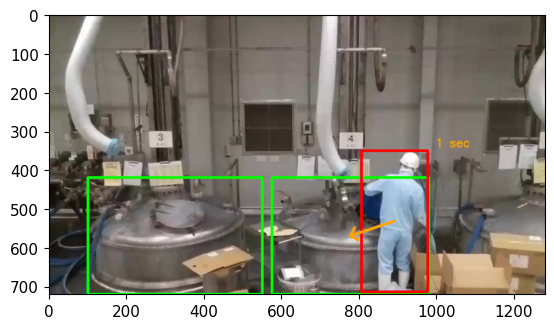

In [28]:
np_img = np.array(img)

# draw tank bounding box

tank_lt = (575, 420)
tank_rb = (980, np_img.shape[0])

cv2.rectangle(np_img, (100, 420), (550, np_img.shape[0]), (0, 255, 0), 5)
cv2.rectangle(np_img, tank_lt, tank_rb, (0, 255, 0), 5)

# draw human bounding box
for j in coords:
    if j[-1] == 0 and j[-2] > 0.5:
        human_lt = (int(j[0]), int(j[1]))
        human_rb = (int(j[2]), int(j[3]))
        
        cv2.rectangle(np_img, human_lt, human_rb, (255, 0, 0), 5)



def check_overlap(l1, r1, l2, r2):     
    # If one rectangle is on left side of other
    if l1[0] > r2[0] or l2[0] > r1[0]:
        return False
 
    # If one rectangle is above other
    if r1[1] < l2[1] or r2[1] < l1[1]:
        return False
 
    return True


# check overlap & draw arrow & count frame
counter = 0
overlap = check_overlap(tank_lt, tank_rb, human_lt, human_rb)
print(overlap)
if overlap:
    tank_center = (int((tank_lt[0]+tank_rb[0])/2), int((tank_lt[1]+tank_rb[1])/2))
    human_center = (int((human_lt[0]+human_rb[0])/2), int((human_lt[1]+human_rb[1])/2))
    
    cv2.arrowedLine(np_img, human_center, tank_center, (255, 165, 0), 5, tipLength=0.2)
    
    counter += 1
    cv2.putText(np_img, str(counter)+' sec', (human_rb[0]+20, human_lt[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 165, 0), 2, cv2.LINE_AA)



plt.imshow(np_img)
plt.show()

In [12]:
# easyocr

reader = easyocr.Reader(['en'], gpu=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

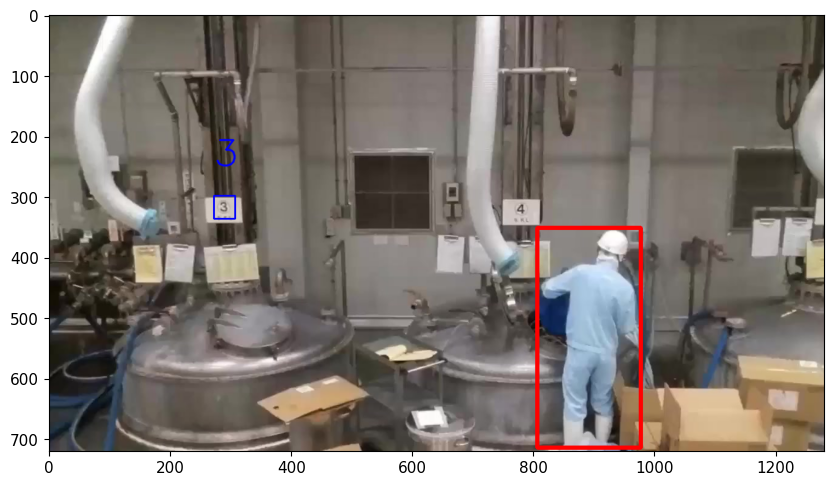

In [17]:
d = reader.readtext(np_img, min_size=5, text_threshold=0.3, mag_ratio=2, allowlist='0123456789')


for i in d:
    if i[-1] > 0.8:
        l = i[0][0][0] - 10
        r = i[0][2][0] + 10
        t = i[0][0][1] - 10
        b = i[0][2][1] + 10
        
        cv2.rectangle(np_img, (l, t), (r, b), (0, 0, 255), 2)
        cv2.putText(np_img, i[1], (l, t - 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(np_img)